conda install pandas numpy matplotlib scikit-learn-intelex numpy=1.23 tensorflow=2.2 tensorflow-gpu=2.2 ipykernel keras

In [46]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as clear
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Functions for evaluation
## Regression
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE
## Classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6113387478291246109
 xla_global_id: -1]

In [47]:
device_name = tf.test.gpu_device_name()
if len(device_name)>0:
    print(f'GPU has been found... device name is{device_name}')
else:
    print('No GPU has been found...')

No GPU has been found...


# Note: Some metrics need to be defined manually

In [48]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [49]:
#load data(sometimes need to use "/")
df = pd.read_csv('DATA/AMD.csv')
# Colab
#df = pd.read_csv('')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-05-19,0.000000,2.708333,2.666667,2.687500,2.687500,66000
1,1980-05-20,0.000000,2.750000,2.677083,2.750000,2.750000,453600
2,1980-05-21,0.000000,2.802083,2.739583,2.781250,2.781250,512400
3,1980-05-22,0.000000,2.916667,2.812500,2.916667,2.916667,499200
4,1980-05-23,0.000000,2.989583,2.895833,2.989583,2.989583,411600
...,...,...,...,...,...,...,...
10845,2023-05-24,105.980003,108.910004,105.639999,108.269997,108.269997,65910500
10846,2023-05-25,117.309998,120.690002,115.800003,120.349998,120.349998,108514700
10847,2023-05-26,122.459999,127.430000,120.889999,127.029999,127.029999,92812000
10848,2023-05-30,130.419998,130.789993,123.510002,125.269997,125.269997,98902300


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [50]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10850 entries, 0 to 10849
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10850 non-null  object 
 1   Open       10850 non-null  float64
 2   High       10850 non-null  float64
 3   Low        10850 non-null  float64
 4   Close      10850 non-null  float64
 5   Adj Close  10850 non-null  float64
 6   Volume     10850 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 593.5+ KB


In [51]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,1980-05-19,2.687500
1,1980-05-20,2.750000
2,1980-05-21,2.781250
3,1980-05-22,2.916667
4,1980-05-23,2.989583


In [52]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Close
count,10850.000000
mean,16.956992
std,22.652365
min,1.620000
25%,5.354167
50%,9.875000
75%,16.062500
max,161.910004


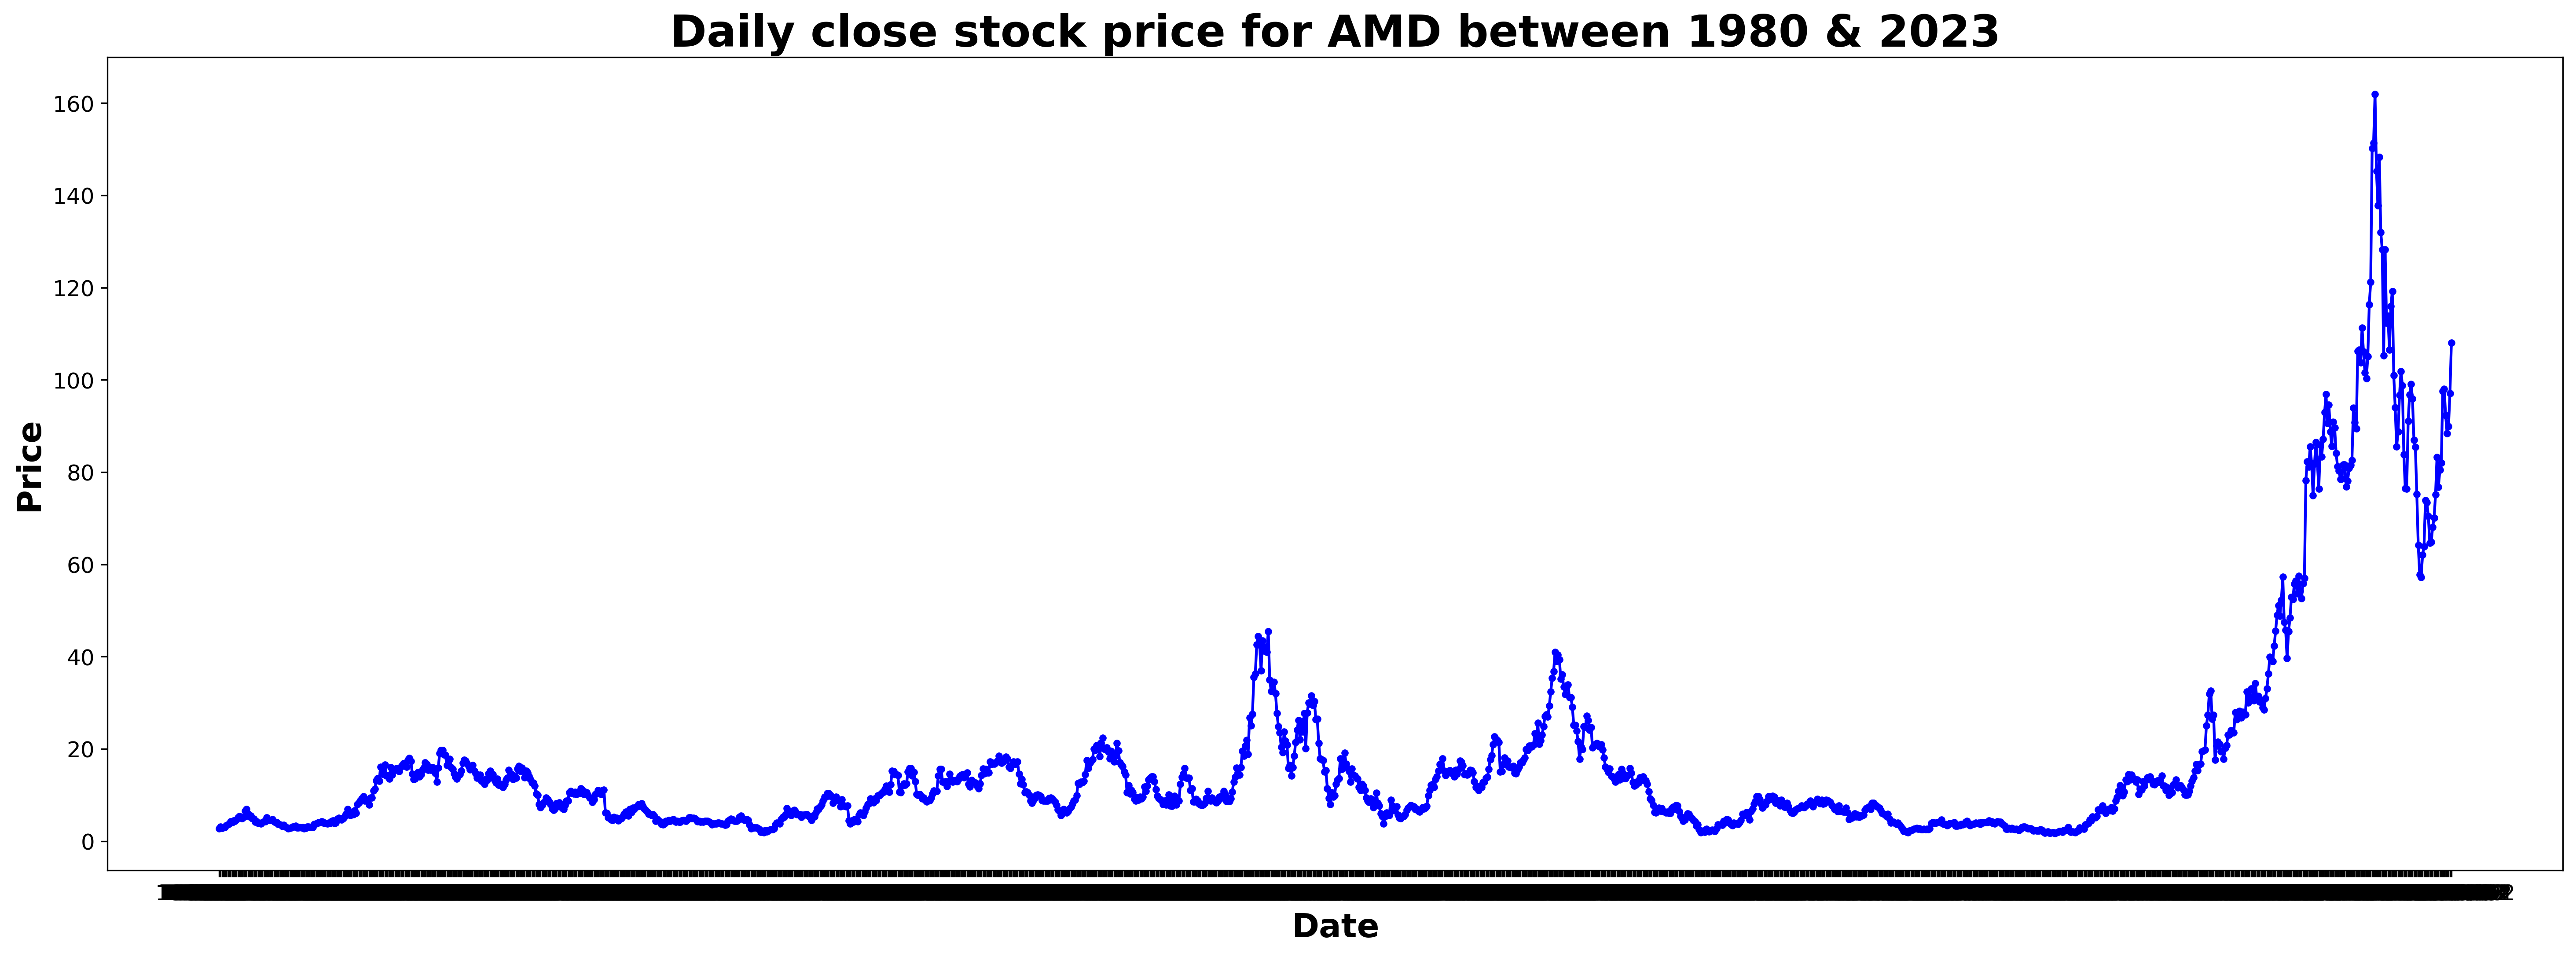

In [53]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily close stock price for AMD between 1980 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'][::7],new_df['Close'][::7],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [54]:
# Create N lags
lags=["Lag_"+str(i) for i in range(1,21)]
for lag in lags:
    new_df[lag]=new_df['Close'].shift(int(lag[4:]))
new_df.head(len(lags)+1)

,Date,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-05-19,2.687500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-05-20,2.750000,2.687500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-05-21,2.781250,2.750000,2.687500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-05-22,2.916667,2.781250,2.750000,2.687500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-05-23,2.989583,2.916667,2.781250,2.750000,2.687500,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1980-05-27,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1980-05-28,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1980-05-29,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1980-05-30,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1980-06-02,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-06-17,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,3.020833,...,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500
1,1980-06-18,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,...,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000
2,1980-06-19,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,...,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250
3,1980-06-20,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,...,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667
4,1980-06-23,2.937500,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,...,3.000000,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10825,2023-05-24,108.269997,108.120003,108.000000,105.820000,107.930000,103.750000,101.480003,97.400002,95.260002,...,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002,85.940002
10826,2023-05-25,120.349998,108.269997,108.120003,108.000000,105.820000,107.930000,103.750000,101.480003,97.400002,...,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003,87.440002
10827,2023-05-26,127.029999,120.349998,108.269997,108.120003,108.000000,105.820000,107.930000,103.750000,101.480003,...,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002,89.370003
10828,2023-05-30,125.269997,127.029999,120.349998,108.269997,108.120003,108.000000,105.820000,107.930000,103.750000,...,95.260002,97.099998,97.019997,95.059998,95.040001,89.839996,86.610001,81.620003,89.910004,89.690002


In [56]:
# Export the data
clean_df.to_csv('DATA/AMD_Lags.csv',index=False, header=True)
clean_df = pd.read_csv('DATA/AMD_Lags.csv')

# 3. Data preprocessing under time-series structure

In [57]:
split_point = int(len(clean_df)*0.8)
print(split_point)

8664


A total of 43 years are in the data set. In this practice, we will use the last nine years of data as the testing set

In [58]:
# Train data
Forecast_train_data=clean_df.iloc[0:split_point,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-06-17,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,3.020833,...,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500
1,1980-06-18,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,...,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000
2,1980-06-19,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,...,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250
3,1980-06-20,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,...,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667
4,1980-06-23,2.937500,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,...,3.000000,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,2014-10-15,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,3.360000,3.400000,...,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000,3.820000
8660,2014-10-16,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,3.360000,...,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000
8661,2014-10-17,2.720000,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,...,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000
8662,2014-10-20,2.670000,2.720000,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,...,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000


In [59]:
# Test data
Forecast_test_data=clean_df.iloc[split_point:,:].copy()
# Forecast_train_data=clean_df.iloc[0:213,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,1980-06-17,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,3.020833,...,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000,2.687500
1,1980-06-18,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,3.000000,...,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250,2.750000
2,1980-06-19,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,2.864583,...,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667,2.781250
3,1980-06-20,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,2.968750,...,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583,2.916667
4,1980-06-23,2.937500,2.927083,2.968750,3.020833,3.062500,3.031250,3.093750,3.093750,3.052083,...,3.000000,3.020833,3.072917,3.020833,3.104167,3.166667,3.083333,3.145833,3.010417,2.989583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8659,2014-10-15,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,3.360000,3.400000,...,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000,3.820000
8660,2014-10-16,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,3.360000,...,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000,3.880000
8661,2014-10-17,2.720000,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,3.280000,...,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000,3.810000
8662,2014-10-20,2.670000,2.720000,2.640000,2.610000,2.620000,2.740000,2.720000,2.950000,3.280000,...,3.400000,3.390000,3.350000,3.410000,3.550000,3.600000,3.630000,3.700000,3.690000,3.760000


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 34 years of data in training data set that are ready to be further splitted into training and validation data set

34 years of data can be evenlly divided into 6 portions

# Expanding window

In [60]:
splice = int(split_point/6)
print(splice)
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:splice*3,:].copy()
Exp_val_1=Forecast_train_data.iloc[splice*3:splice*4,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:splice*4,:].copy()
Exp_val_2=Forecast_train_data.iloc[splice*4:splice*5,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:splice*5,:].copy()
Exp_val_3=Forecast_train_data.iloc[splice*5:splice*6,:].copy()

1444


# Rolling window

In [61]:
splice = int(split_point/6)
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:splice*3,:].copy()
Rol_val_1=Forecast_train_data.iloc[splice*3:splice*4,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[splice:splice*4,:].copy()
Rol_val_2=Forecast_train_data.iloc[splice*4:splice*5,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[splice*2:splice*5,:].copy()
Rol_val_3=Forecast_train_data.iloc[splice*5:splice*6,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [62]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=lags

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=lags

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [63]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=lags

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=lags

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net 

In [64]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20
0,0.053009,0.055874,0.055874,0.053964,0.050143,0.045368,0.051576,0.052531,0.054919,0.052531,0.056351,0.059217,0.055396,0.058262,0.052054,0.051098,0.047756,0.041547,0.040115,0.037249
1,0.054441,0.053009,0.055874,0.055874,0.053964,0.050143,0.045368,0.051576,0.052531,0.054919,0.052531,0.056351,0.059217,0.055396,0.058262,0.052054,0.051098,0.047756,0.041547,0.040115
2,0.052531,0.054441,0.053009,0.055874,0.055874,0.053964,0.050143,0.045368,0.051576,0.052531,0.054919,0.052531,0.056351,0.059217,0.055396,0.058262,0.052054,0.051098,0.047756,0.041547
3,0.050143,0.052531,0.054441,0.053009,0.055874,0.055874,0.053964,0.050143,0.045368,0.051576,0.052531,0.054919,0.052531,0.056351,0.059217,0.055396,0.058262,0.052054,0.051098,0.047756
4,0.048233,0.050143,0.052531,0.054441,0.053009,0.055874,0.055874,0.053964,0.050143,0.045368,0.051576,0.052531,0.054919,0.052531,0.056351,0.059217,0.055396,0.058262,0.052054,0.051098


In [65]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 20


# Important: Define customized loss function (RMSE)

In [66]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from tensorflow.keras.saving import get_custom_objects #for colab version problem
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

Note: The following code demonstrate the most common style for creating net

In [67]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [68]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=40, input_dim=len(lags), activation='relu'))

# 6.3 Add 3 dense layers
dense_generator(model,5,40)

# 6.4 Add dropout layer
model.add(Dropout(rate=0.4))

# 6.6 Add regularization layer optional
#model.add(BatchNormalization())

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
# opt=Adam(learning_rate=0.002,beta_1=0.95)
opt=Adam(learning_rate=0.001,beta_1=0.9)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                840       
                                                                 
 dense_1 (Dense)             (None, 80)                3280      
                                                                 
 dense_2 (Dense)             (None, 160)               12960     
                                                                 
 dense_3 (Dense)             (None, 320)               51520     
                                                                 
 dense_4 (Dense)             (None, 640)               205440    
                                                                 
 dense_5 (Dense)             (None, 1280)              820480    
                                                                 
 dropout (Dropout)           (None, 1280)              0

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [69]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=100, batch_size=256,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/100
17/17 [==============================] - 1s 35ms/step - loss: 4.6962 - mean_absolute_percentage_error: 50.2344 - val_loss: 9.0185 - val_mean_absolute_percentage_error: 57.9612
Epoch 2/100
17/17 [==============================] - 0s 24ms/step - loss: 1.0948 - mean_absolute_percentage_error: 12.1502 - val_loss: 7.5633 - val_mean_absolute_percentage_error: 47.7729
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 0.7525 - mean_absolute_percentage_error: 8.3929 - val_loss: 7.6170 - val_mean_absolute_percentage_error: 48.5345
Epoch 4/100
17/17 [==============================] - 0s 23ms/step - loss: 0.6073 - mean_absolute_percentage_error: 6.7503 - val_loss: 7.3089 - val_mean_absolute_percentage_error: 46.6570
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 0.5301 - mean_absolute_percentage_error: 5.8011 - val_loss: 7.6394 - val_mean_absolute_percentage_error: 49.0374
Epoch 6/100
17/17 [==============================] - 0s 23ms/st

In [70]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

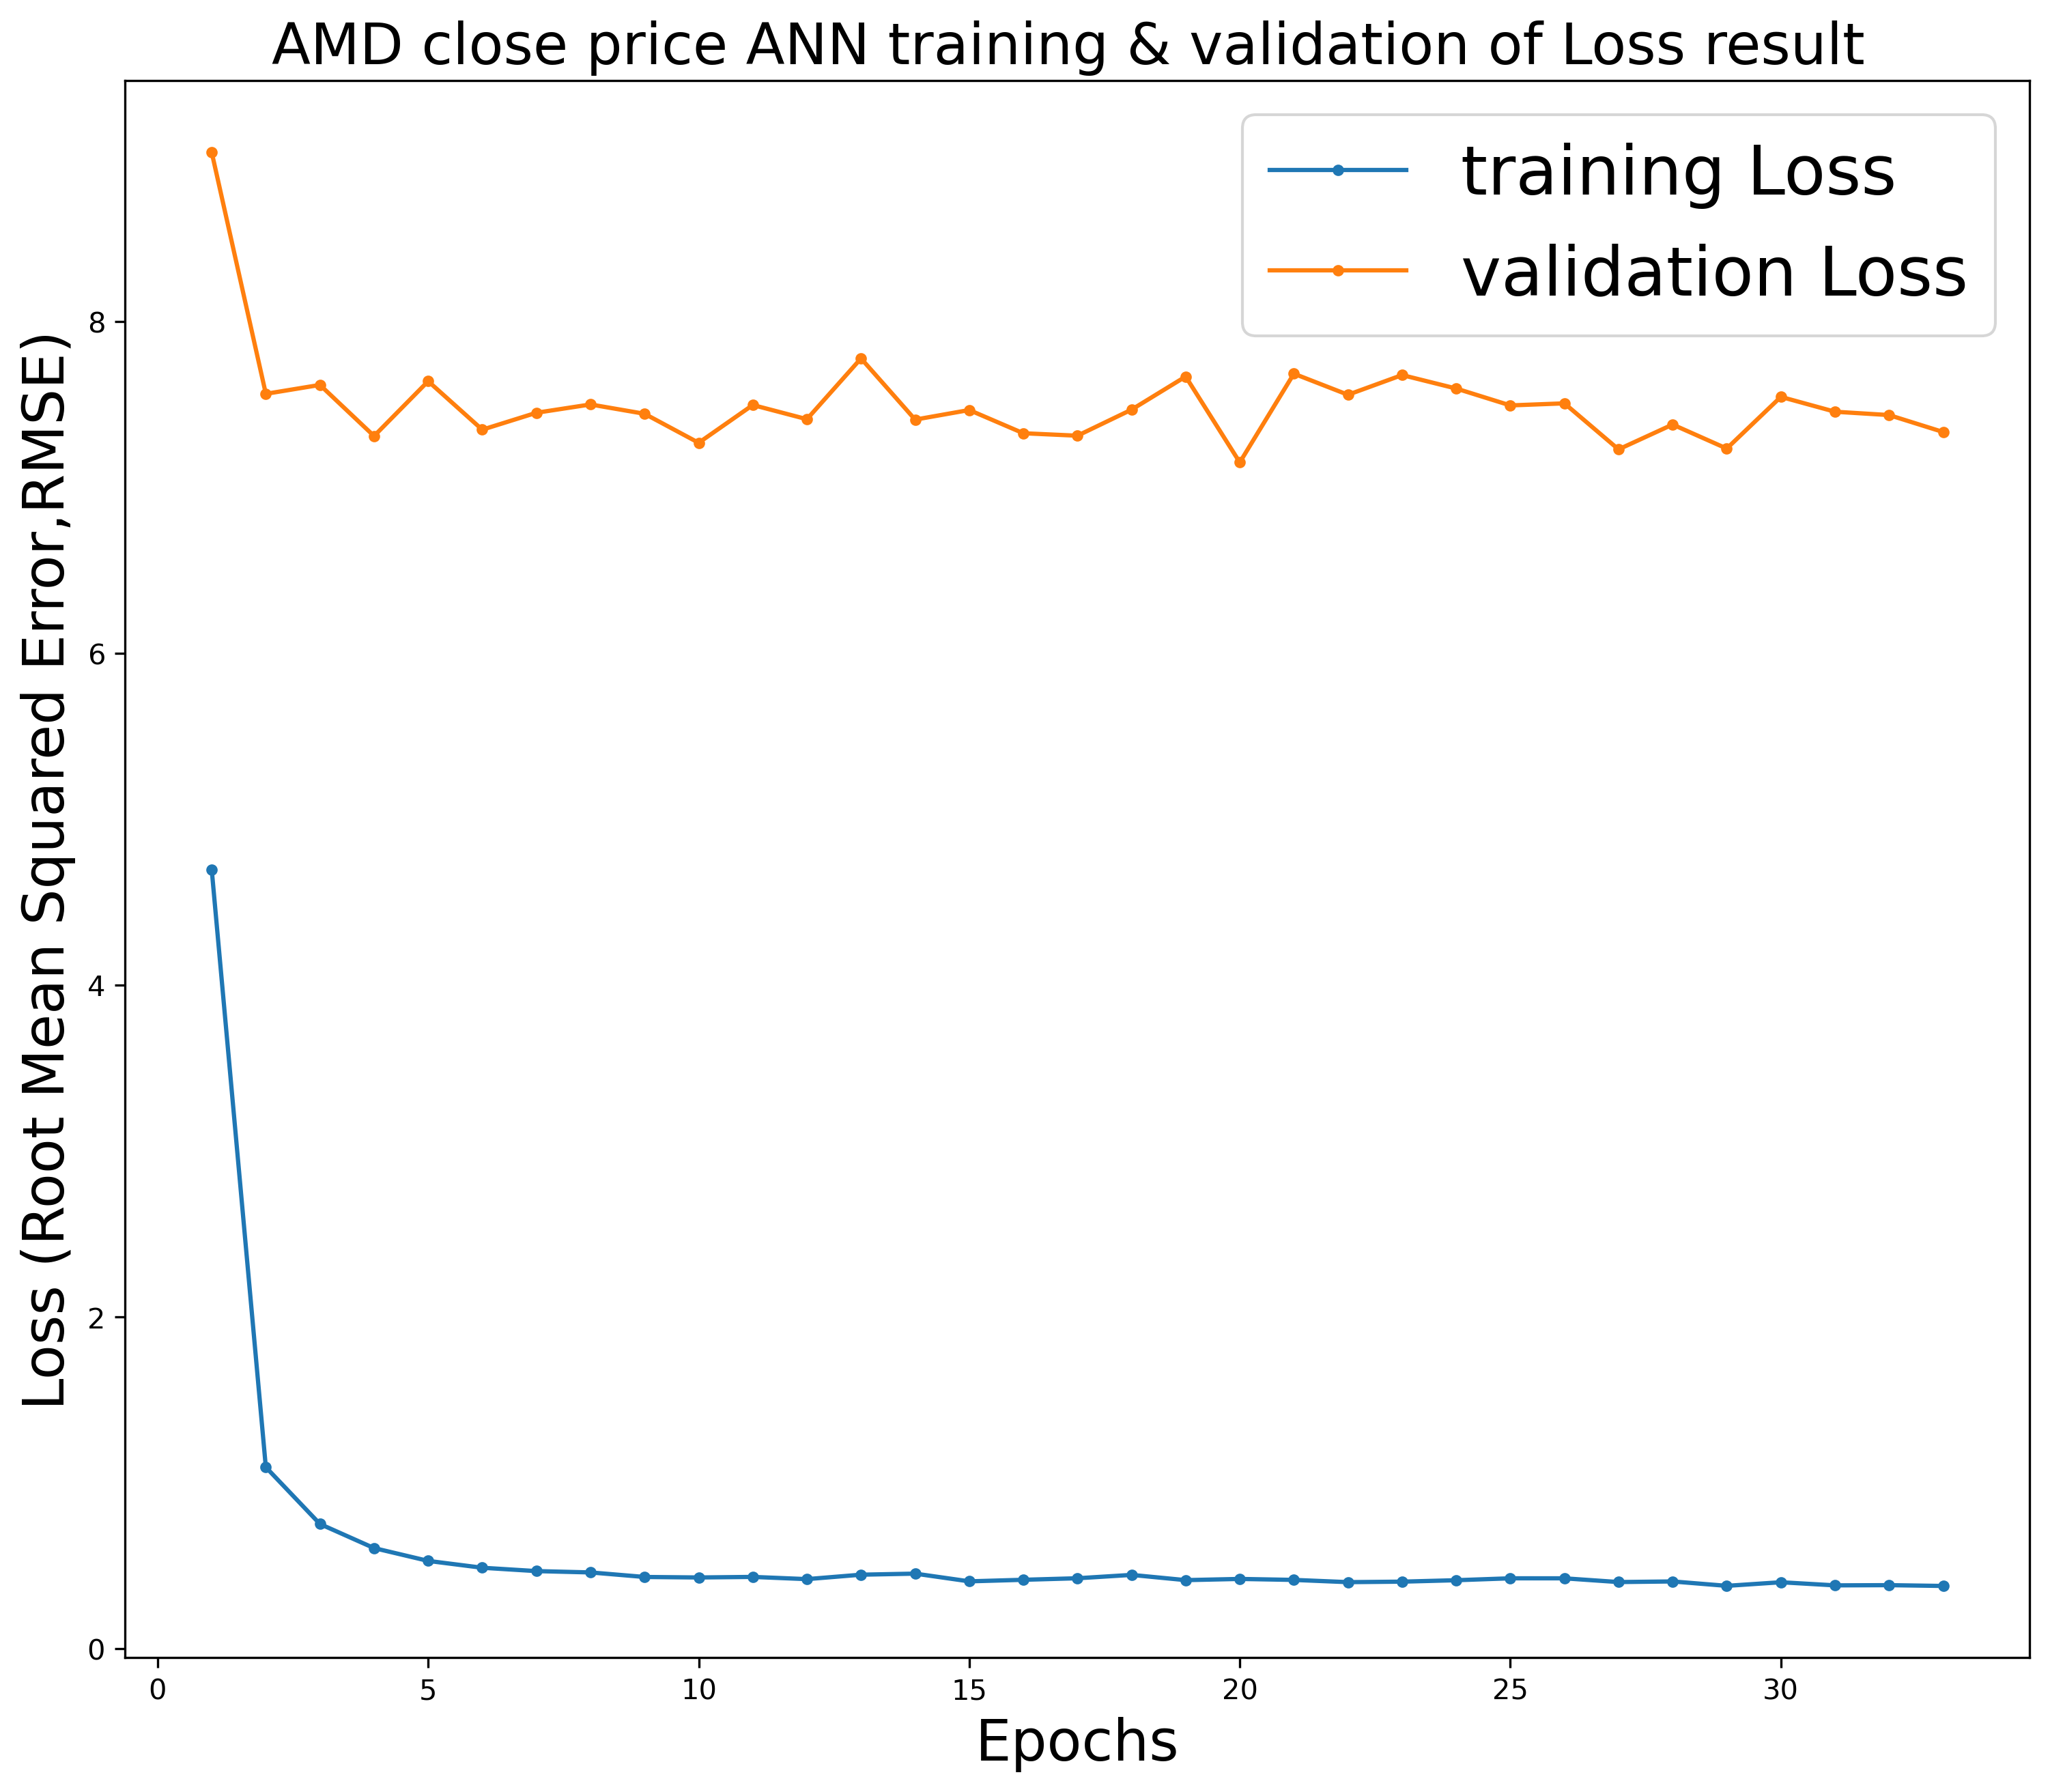

In [71]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('AMD close price ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

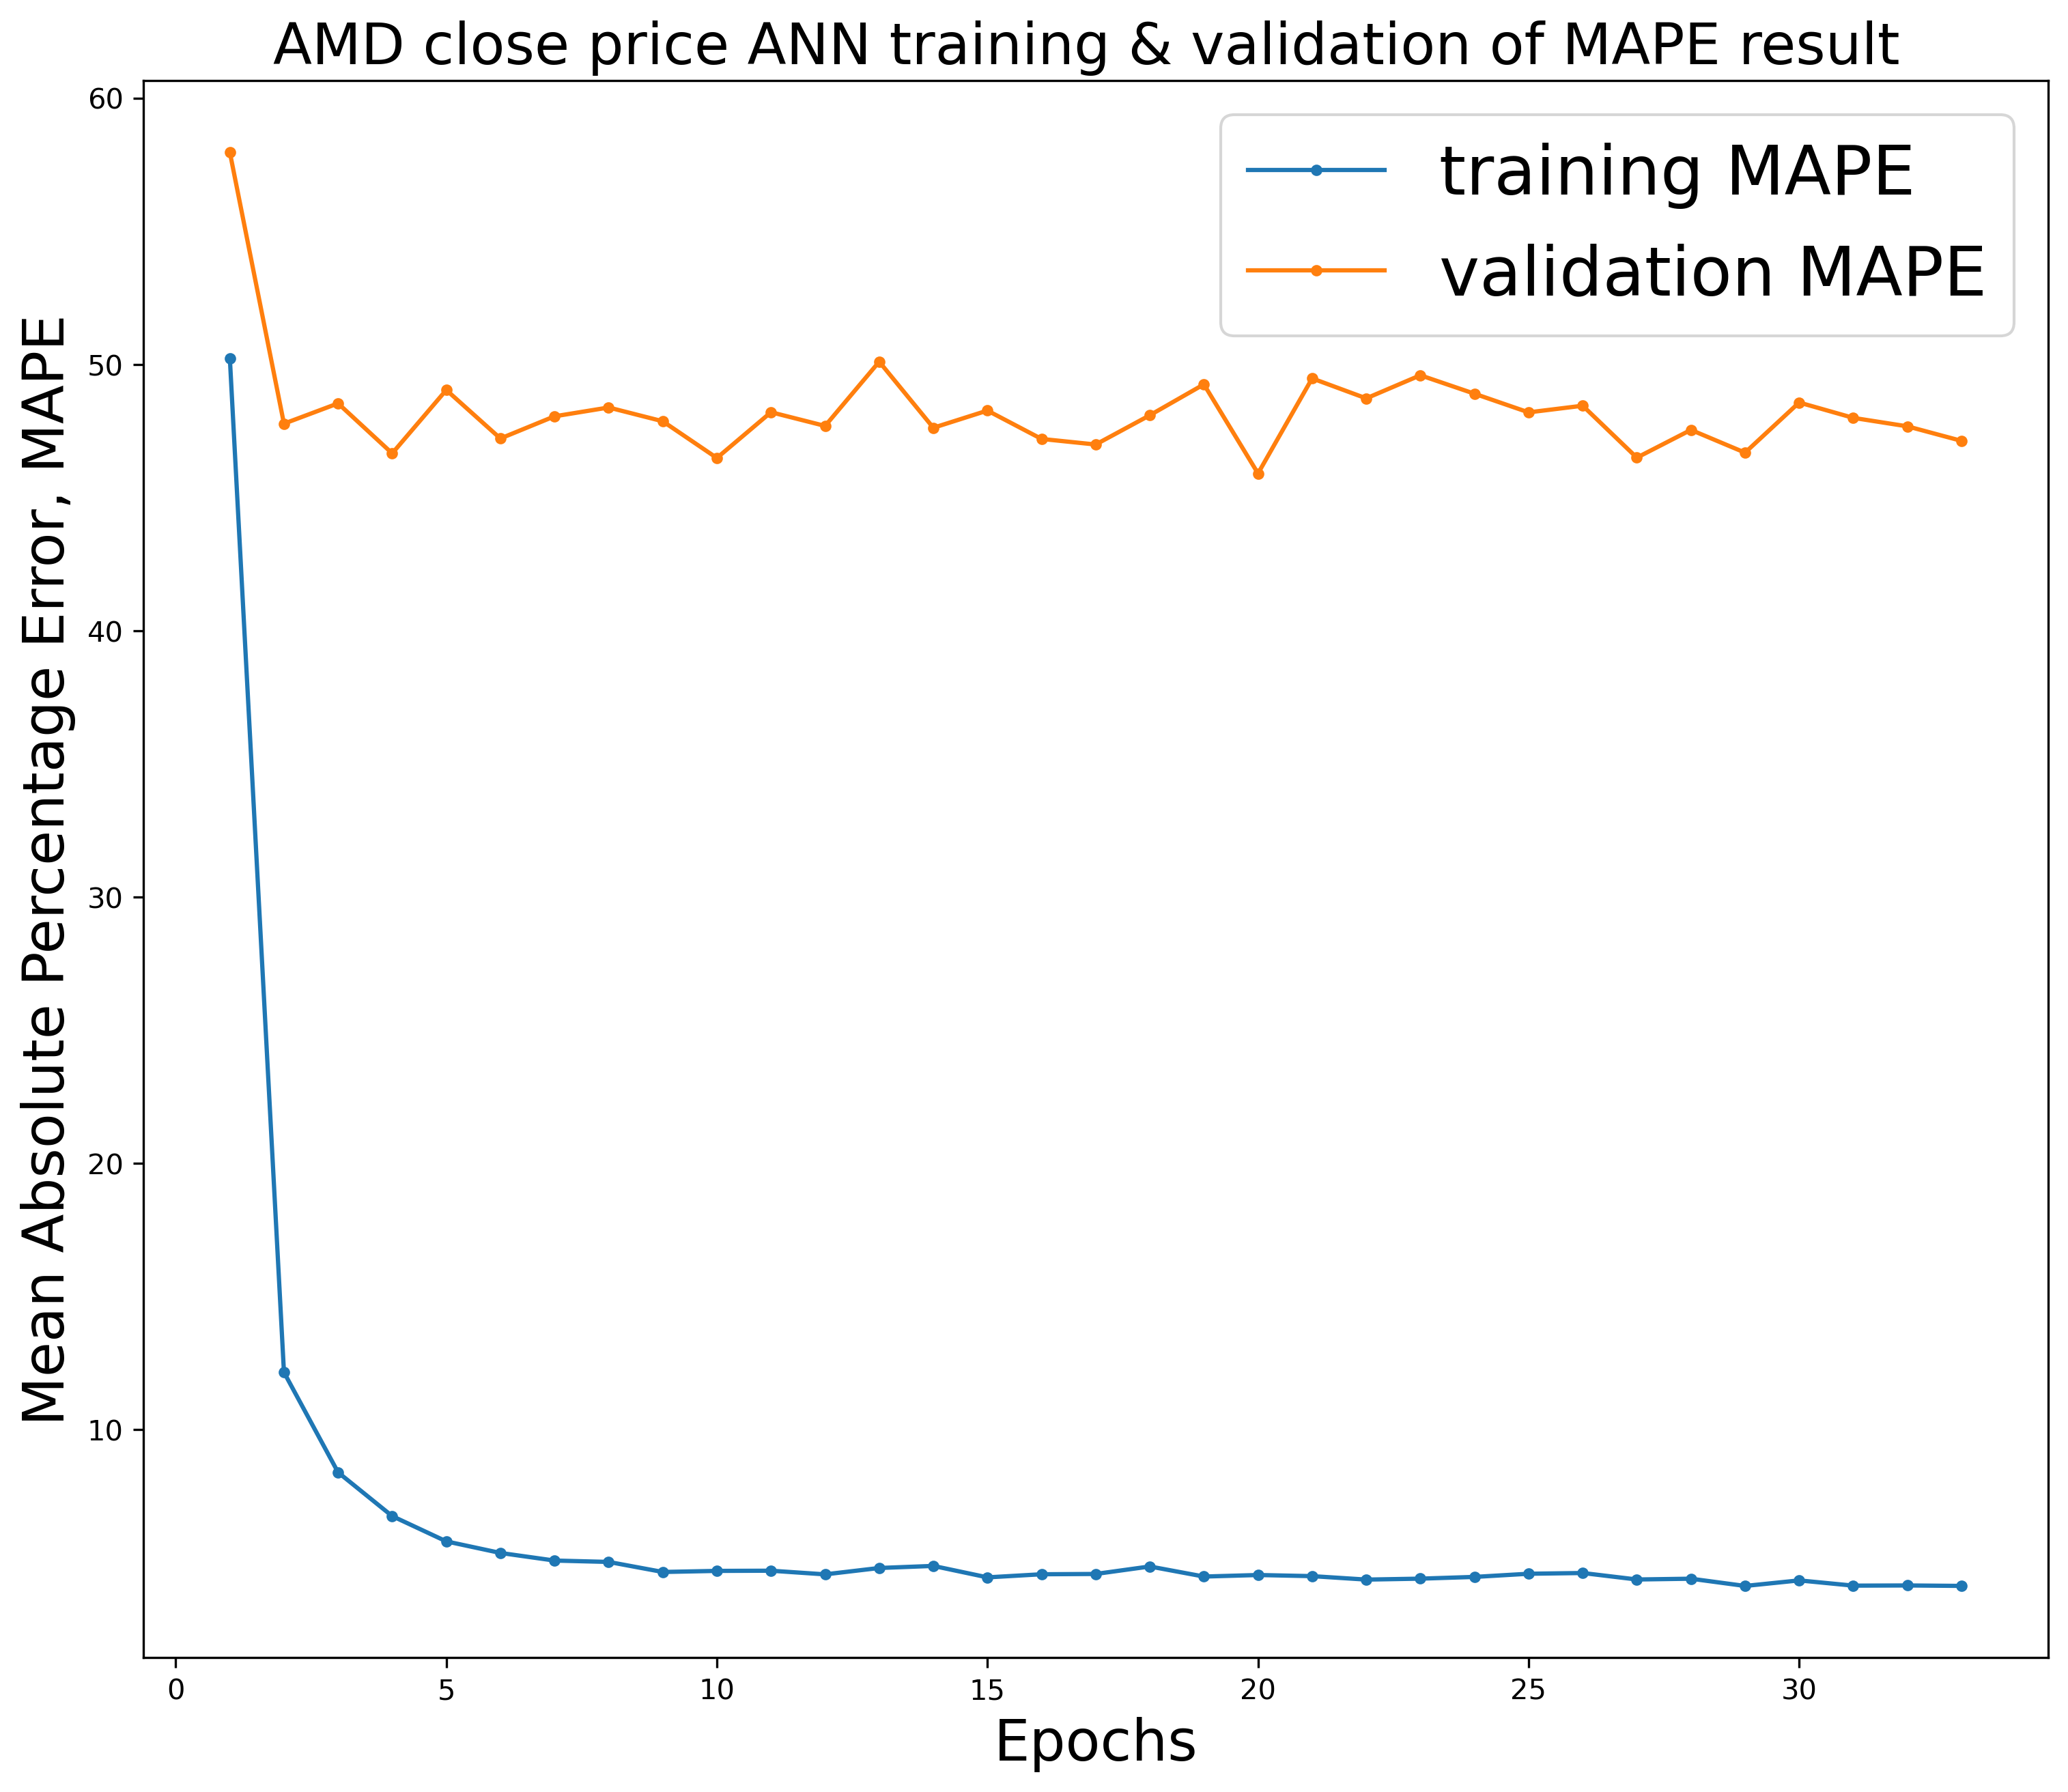

In [72]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('AMD close price ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [73]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [74]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=40, input_dim=len(lags), activation='relu'))

# Add 10 dense layers
dense_generator(Fmodel,5,40)

# Add dropout layer
Fmodel.add(Dropout(rate=0.4))

# Add regularization layer optional
#model.add(BatchNormalization())

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
opt=SGD(learning_rate=0.001,momentum=0.5)
# opt=Adam(learning_rate=0.002,beta_1=0.95)
# opt=Adam(learning_rate=0.001,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                840       
                                                                 
 dense_1 (Dense)             (None, 80)                3280      
                                                                 
 dense_2 (Dense)             (None, 160)               12960     
                                                                 
 dense_3 (Dense)             (None, 320)               51520     
                                                                 
 dense_4 (Dense)             (None, 640)               205440    
                                                                 
 dense_5 (Dense)             (None, 1280)              820480    
                                                                 
 dropout (Dropout)           (None, 1280)              0

In [75]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=100, batch_size=256,verbose=1)

Epoch 1/100
34/34 [==============================] - 1s 15ms/step - loss: 2.4966 - mean_absolute_percentage_error: 23.3232
Epoch 2/100
34/34 [==============================] - 1s 16ms/step - loss: 1.1159 - mean_absolute_percentage_error: 10.6284
Epoch 3/100
34/34 [==============================] - 1s 18ms/step - loss: 1.0420 - mean_absolute_percentage_error: 9.9794
Epoch 4/100
34/34 [==============================] - 1s 16ms/step - loss: 0.9863 - mean_absolute_percentage_error: 9.3697
Epoch 5/100
34/34 [==============================] - 1s 18ms/step - loss: 0.9190 - mean_absolute_percentage_error: 8.7151
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.8800 - mean_absolute_percentage_error: 8.3797
Epoch 7/100
34/34 [==============================] - 1s 18ms/step - loss: 0.8609 - mean_absolute_percentage_error: 8.1287
Epoch 8/100
34/34 [==============================] - 1s 22ms/step - loss: 0.8742 - mean_absolute_percentage_error: 8.1798
Epoch 9/100
34/34 [===

In [76]:
# 7.3 Save the trained model
Fmodel.save('./Rainfall_forecast_ANN_trained_model.h5')
# Colab
#model.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [77]:
# 7.4 Restore the saved model for testing
ANN_model=keras.models.load_model('./Rainfall_forecast_ANN_trained_model.h5')
# Colab
#ANN_model=keras.models.load_model('')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [78]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [79]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [80]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
8664,2014-10-22,2.640000,2.660000,0.020000
8665,2014-10-23,2.690000,2.600000,0.090000
8666,2014-10-24,2.680000,2.600000,0.080000
8667,2014-10-27,2.660000,2.610000,0.050000
8668,2014-10-28,2.720000,2.620000,0.100000
...,...,...,...,...
10825,2023-05-24,108.269997,104.800003,3.469994
10826,2023-05-25,120.349998,105.809998,14.540000
10827,2023-05-26,127.029999,113.500000,13.529999
10828,2023-05-30,125.269997,118.849998,6.419999


In [81]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 1.735
MSE: 8.338
RMSE: 2.888
MAPE: 3.984 %
SMAPE: 4.088 %
RAE: 0.05
MRAE: 2.289332910021256e-05
MdRAE: 0.028 bench: 41.989
RSE: 0.005
RRSE: 0.073


#  Plot for comparing true value & predicted value 

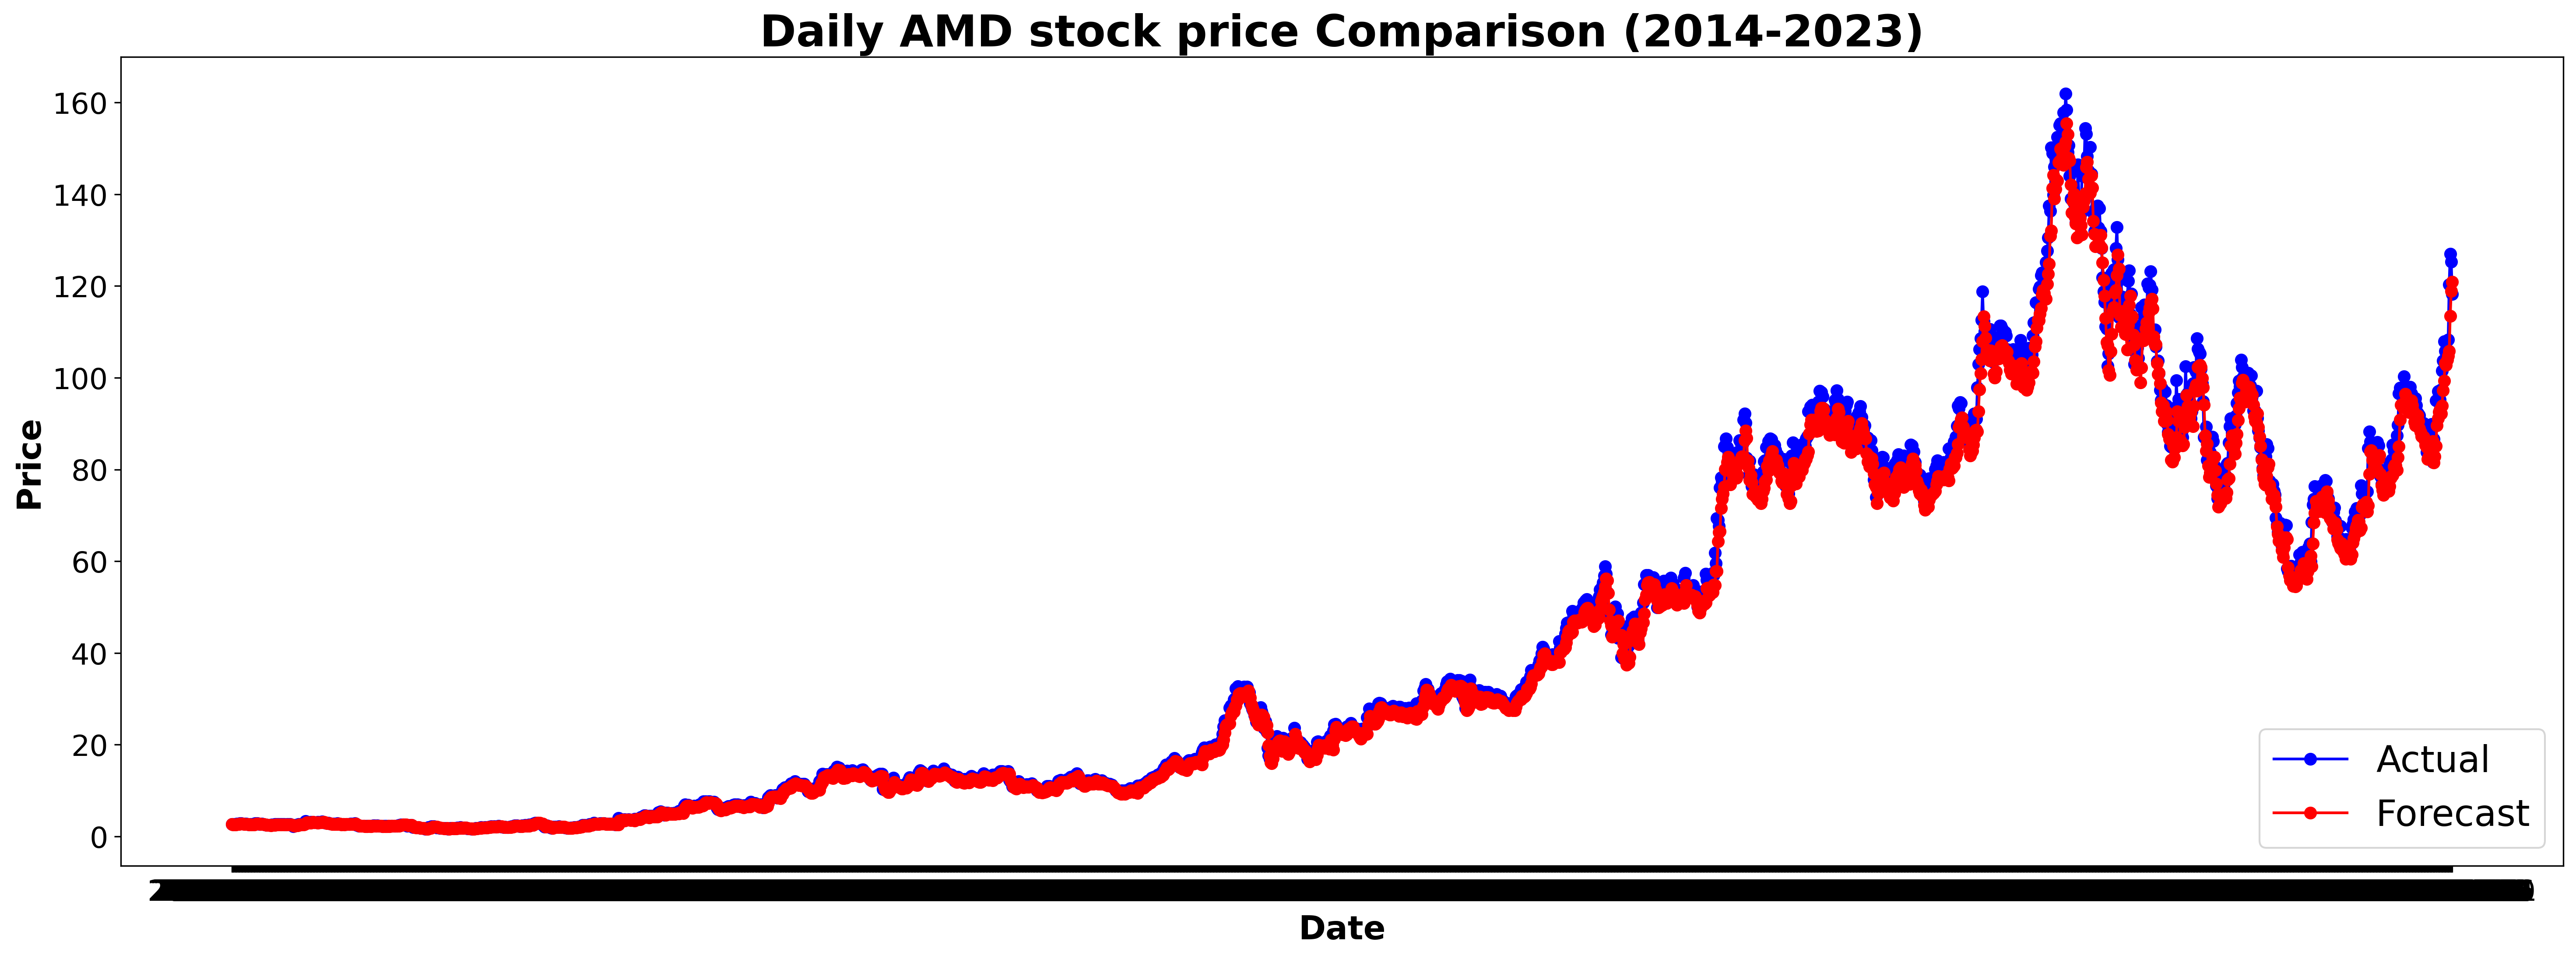

In [82]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily AMD stock price Comparison (2014-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[split_point:,0],clean_df.iloc[split_point:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

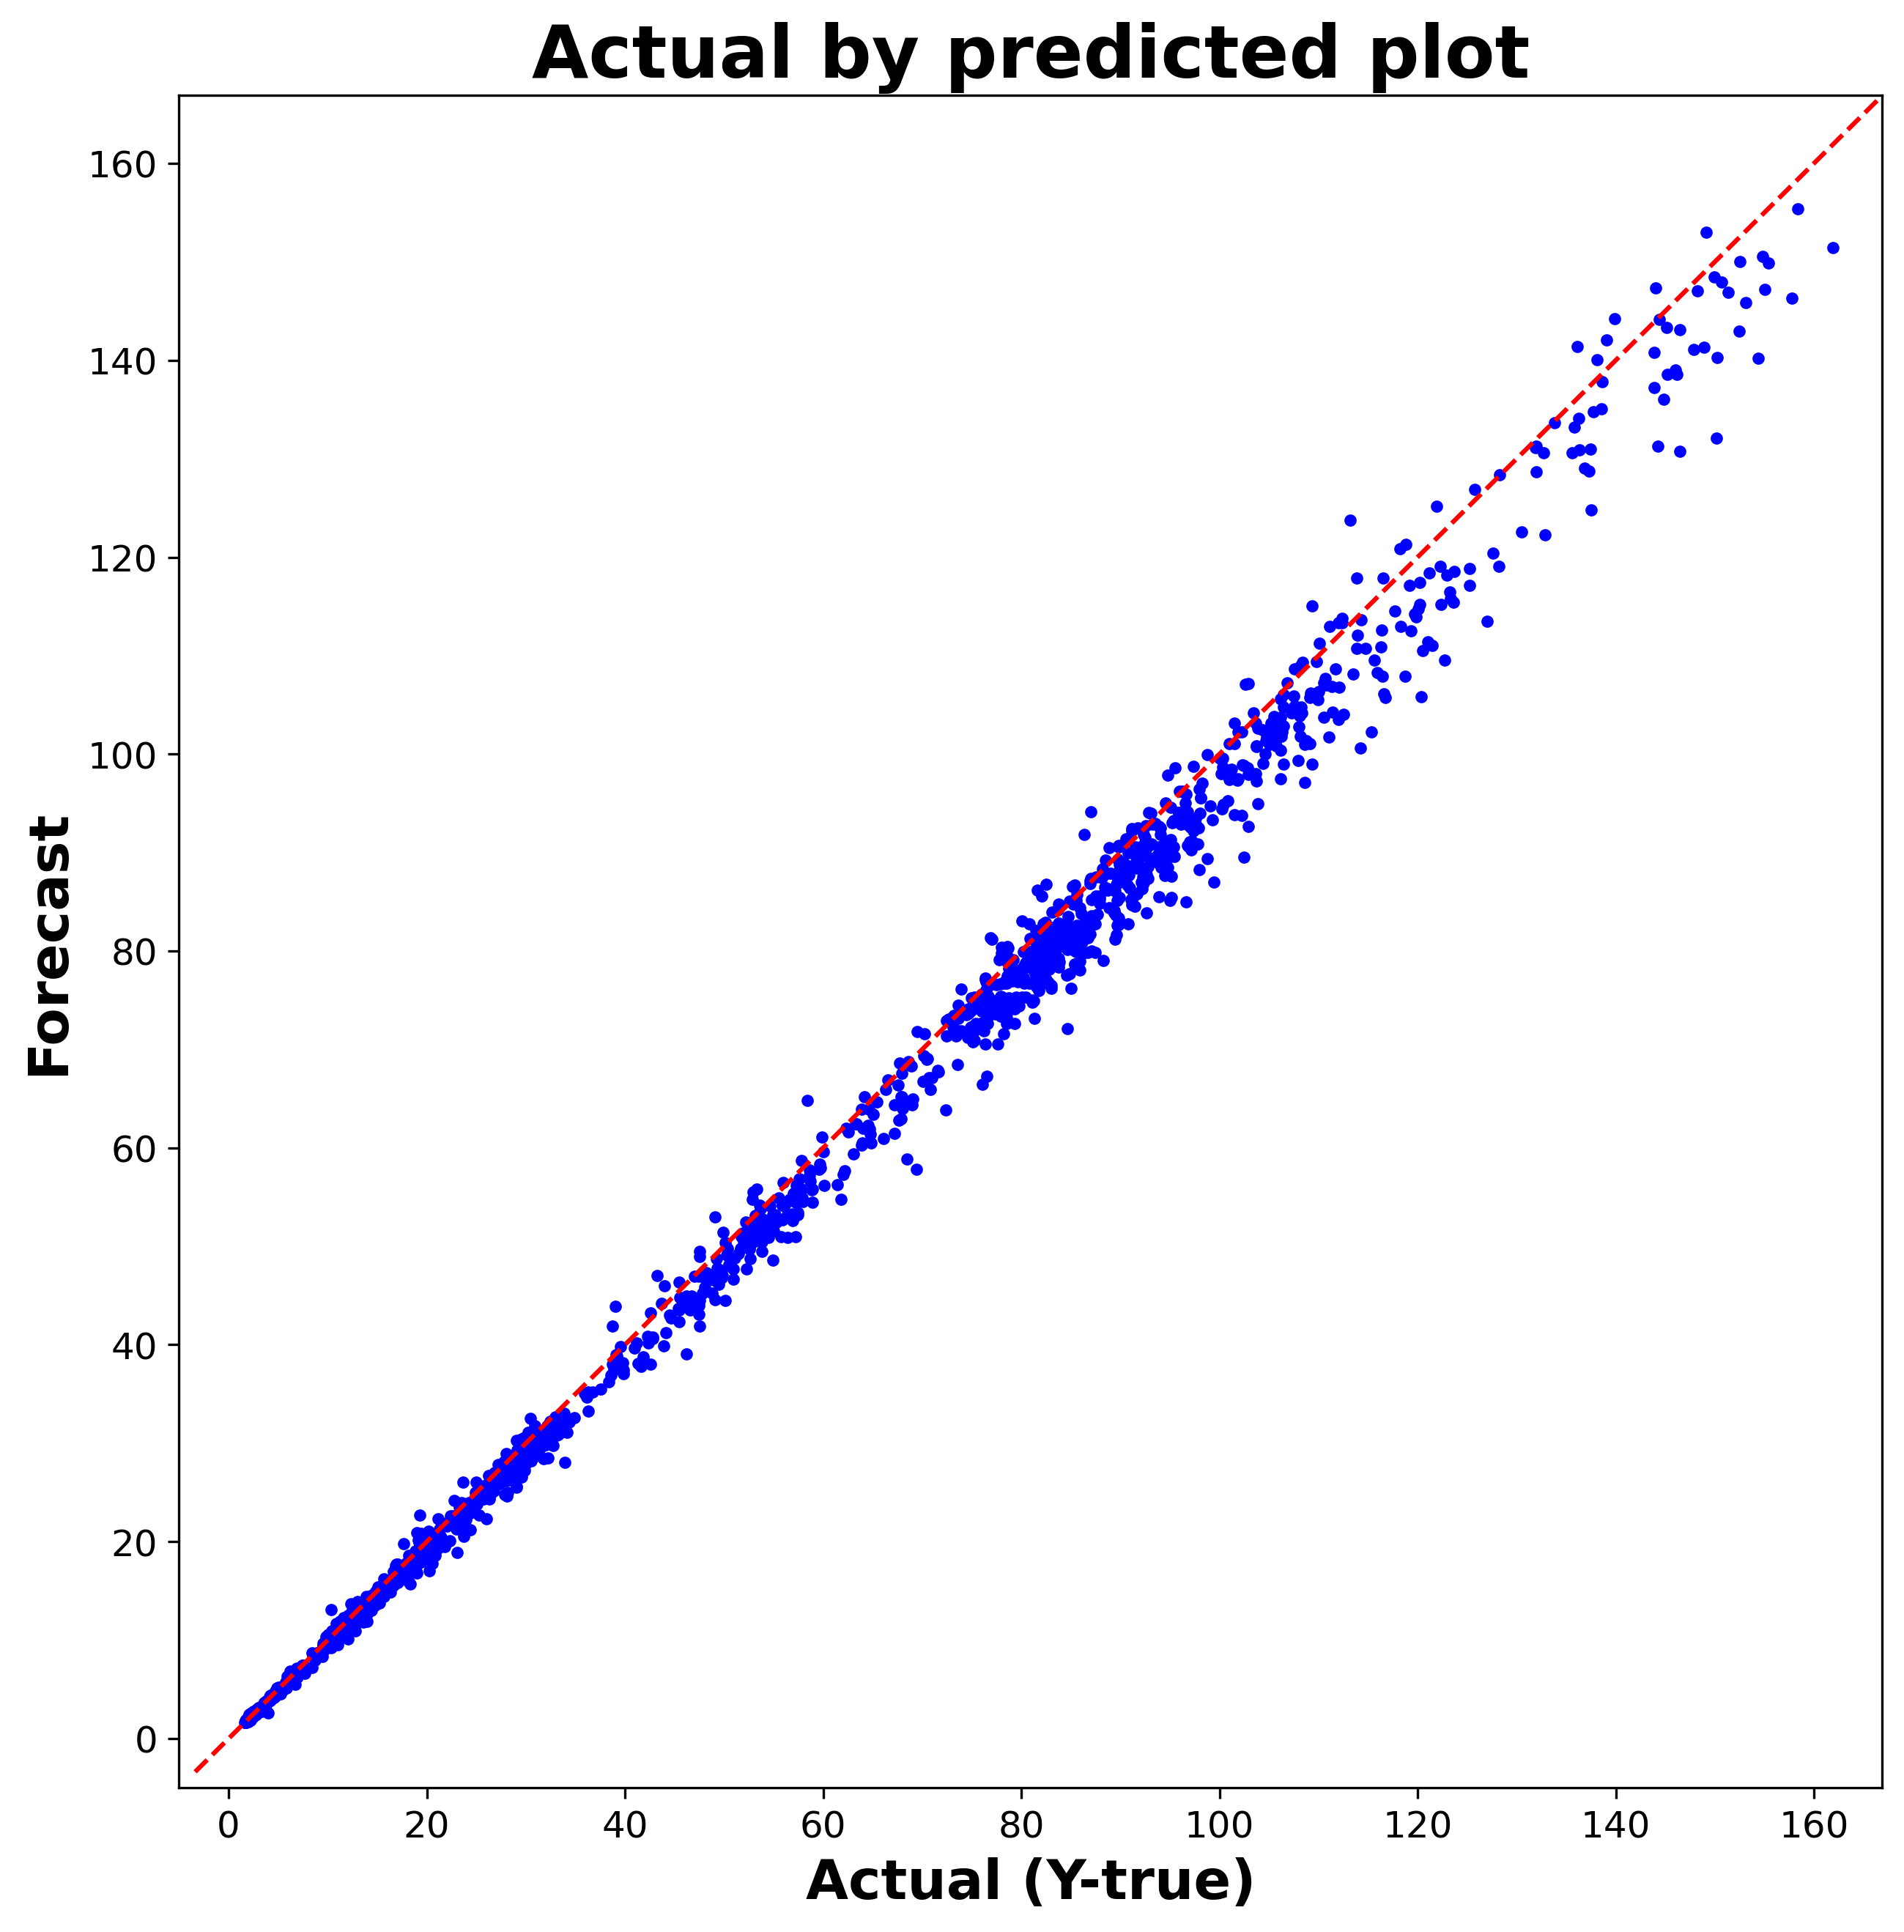

In [83]:
# Lock the scale of axis by Y_true
max_value=Results['Y_true'].max()+5
min_value=Results['Y_true'].min()-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()